In [307]:
import pandas as pd
import numpy as np

import mplfinance as fplt

import talib as ta


In [343]:
data_path = "C:\\Users\\fleut\\ForexAI\\data\\FX_M5\\EURUSD_M5.csv"

df = pd.read_csv(data_path,
                     sep='\t',
                     names=['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume'],
                     skiprows=1
                     )
df[['Open','High','Low','Close']] = df[['Open','High','Low','Close']].apply(pd.to_numeric, errors='coerce')   
df = df.tail(380) #for testing purpose
df.index = pd.DatetimeIndex(df['DateTime'])

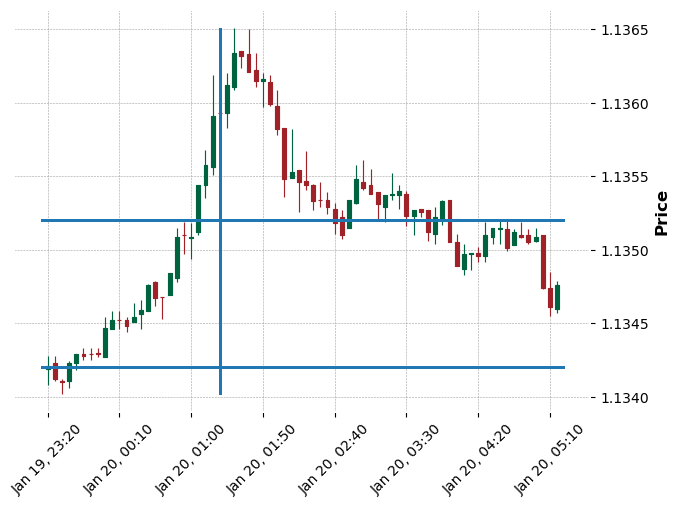

144 2022-01-20 01:20:00
main profile: 64.81 %   / 30.77 %   / 38.46 %
final balance: 46.13 %   / 53.87 %   / 0.0 %
output balance: 95.25 %   / 4.75 %   / 0.0 %


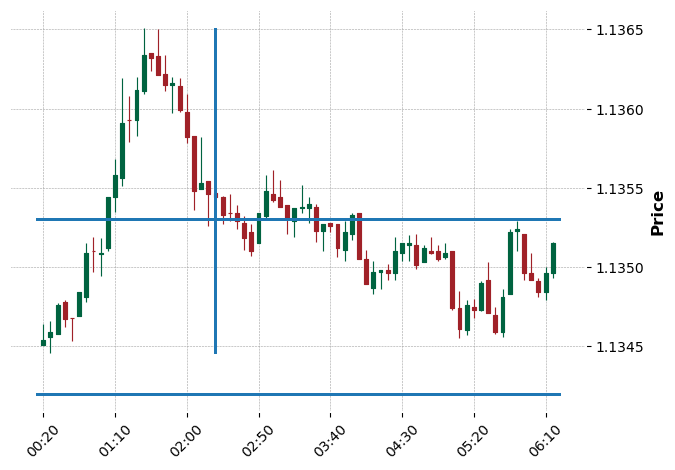

156 2022-01-20 02:20:00
main profile: 61.68 %   / 31.03 %   / 36.21 %
final balance: -116.28 %   / 216.28 %   / -0.0 %
output balance: 43.53 %   / 56.47 %   / 0.0 %


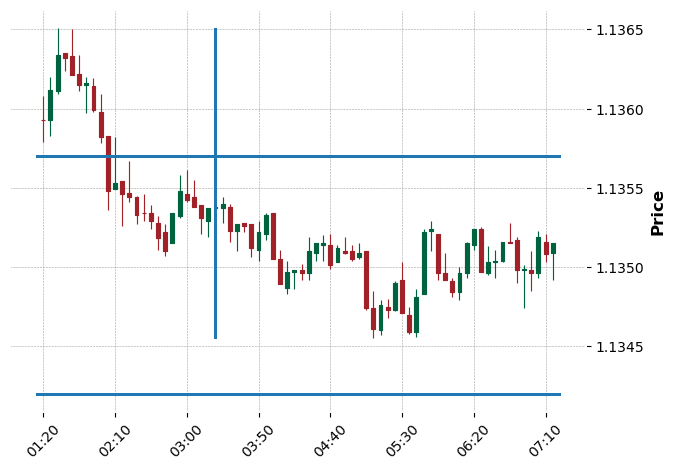

168 2022-01-20 03:20:00
main profile: 72.49 %   / 44.83 %   / 43.1 %
final balance: 0.0 %   / 100.0 %   / 0.0 %
output balance: 0.0 %   / 100.0 %   / 0.0 %


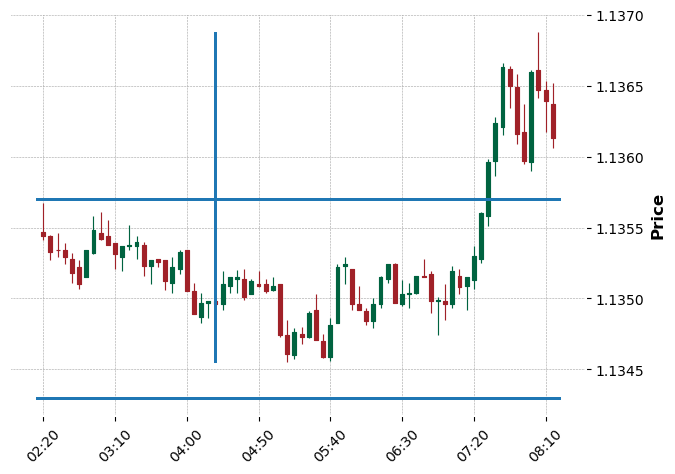

180 2022-01-20 04:20:00
main profile: 73.56 %   / 48.0 %   / 36.0 %
final balance: 0.0 %   / 100.0 %   / 0.0 %
output balance: 0.0 %   / 100.0 %   / 0.0 %


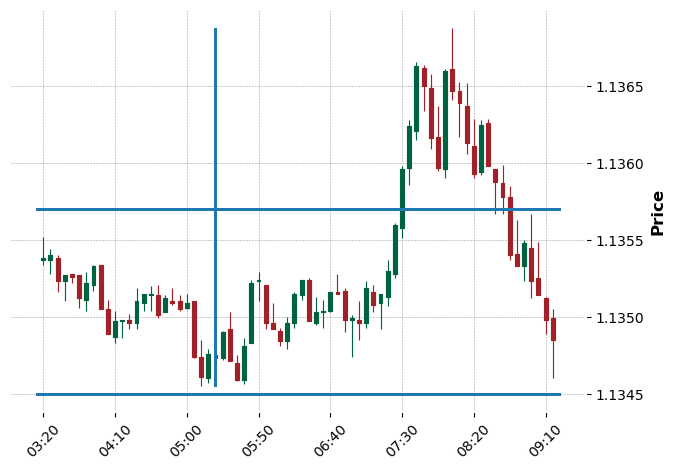

192 2022-01-20 05:20:00
main profile: 62.77 %   / 40.0 %   / 40.0 %
final balance: 0.0 %   / 100.0 %   / 0.0 %
output balance: 0.0 %   / 100.0 %   / 0.0 %


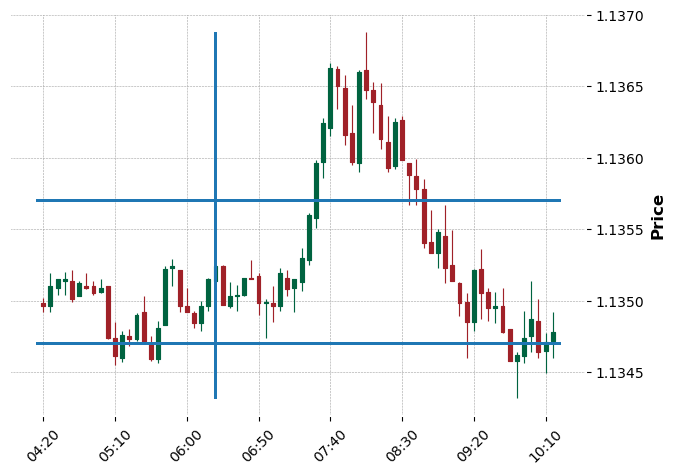

204 2022-01-20 06:20:00
main profile: 58.39 %   / 32.0 %   / 44.0 %
final balance: 0.0 %   / 89.71 %   / 10.29 %
output balance: 56.52 %   / 43.48 %   / 0.0 %


In [348]:

row_size = 0.0001
clen=144
fblen=12
oblen=24
step = 0.0001

l_min = df.Low.min()
h_max = df.High.max()

df['first_row'] = np.rint((df.Low-l_min) / row_size).astype(int)
df['last_row'] = np.rint((df.High-l_min) / row_size).astype(int)
        
for s in range(clen,len(df)-clen-oblen,12):
    
    sub_df = df[s-clen:s]
    r_min =  sub_df.first_row.min() 
    c = np.zeros(sub_df.last_row.max() - r_min)       
    for v,a,b in zip(sub_df.Volume.values, sub_df.first_row, sub_df.last_row):
        c[a-r_min:b+1-r_min] += (v/(1+b-a))     
    id = np.arange(sub_df.first_row.min(),sub_df.last_row.max())
    idx = np.round(l_min + (row_size/2) + id*row_size,4)          
    profile = pd.Series(data=c, index=idx)

    stats = np.zeros((len(profile),len(profile)))
    for w in range(len(profile)//3,2*len(profile)//3):
        for i in range(0,len(profile)-w):
            stats[w,i]=profile.values[i:i+w].sum()/np.power(w,0.75)

    w,i = np.unravel_index(np.argmax(stats),stats.shape)

    c = ['blue']*len(profile)
    c[i:i + (w)] = ['red']*(w)
        
    chan_dn=profile.index[i] - step
    chan_up=profile.index[i+w] + step
    
    #Profile stats
    st1 = np.round(100*profile.values[i:i + w].sum() / profile.values.sum(),2)
    st2 = np.round(100*w/len(profile),2)
    st3 = np.round(100*(i+i+w)/(2*len(profile)),2)
    
    # final balance
    fb_up,fb_mid,fb_dn=0,0,0
    for j in range(s-fblen,s):
        fb_up += max(0,df.High.values[j] - chan_up) - max(0,df.Low.values[j] - chan_up)
        fb_mid += max(0,(df.High.values[j] - df.Low.values[j]) - max(0,df.High.values[j] - chan_up) - max(0,chan_dn - df.Low.values[j]))
        fb_dn += max(0,chan_dn - df.Low.values[j]) - max(0,chan_dn - df.High.values[j])
        
    tot = fb_up+fb_mid+fb_dn
    fb_up = np.round(100*fb_up/tot,2)
    fb_mid = np.round(100*fb_mid/tot,2)
    fb_dn = np.round(100*fb_dn/tot,2)
    
    #output
    ob_up,ob_mid,ob_dn=0,0,0
    for j in range(s,s+oblen):
        ob_up += max(0,df.High.values[j] - chan_up) - max(0,df.Low.values[j] - chan_up)
        ob_mid += max(0,(df.High.values[j] - df.Low.values[j]) - max(0,df.High.values[j] - chan_up) - max(0,chan_dn - df.Low.values[j]))
        ob_dn += max(0,chan_dn - df.Low.values[j]) - max(0,chan_dn - df.High.values[j])
        
    tot = ob_up+ob_mid+ob_dn
    ob_up = np.round(100*ob_up/tot,2)
    ob_mid = np.round(100*ob_mid/tot,2)
    ob_dn = np.round(100*ob_dn/tot,2)
    
    #if(st1 > 60) and (st2 < 40) : 

    ts = pd.to_datetime(str(df.index.values[s])) 

    fplt.plot(
        df[s-fblen*2:s+2*oblen],
        type='candle',
        style='charles',
        hlines=[chan_dn,chan_up],
        vlines = ts.strftime('%Y-%m-%d %H:%M')
    )
    

    print(s,df.DateTime.values[s])
    print('main profile:', st1,'%   /', st2,'%   /', st3,'%')
    print('final balance:', fb_up,'%   /', fb_mid,'%   /', fb_dn,'%')
    print('output balance:', ob_up,'%   /', ob_mid,'%   /', ob_dn,'%')


'2022-01-20 06:40'